# MeasureSoftGram 2021/02 - Analytics 

#### Date: 2021/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2021/02
##### Professor: Hilmer Neri

##### Members:

- Igor Batista Paiva
- Renan Cristyan
- Rhuan Queiroz
- Thiago Lopes

### LIBRARIES

In [125]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [126]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [127]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [128]:
jsons = glob('../analytics-raw-data/*.json') # add your path here

In [129]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = pd.concat([df, base_component_df], ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2021.2-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [130]:
base_component_df = create_base_component_df(jsons)

In [131]:
base_component_df.head(20)

,metric,value,bestValue,filename,repository,version
0,duplicated_lines_density,0.0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
1,functions,17,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
2,test_execution_time,534,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
3,test_failures,0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
4,test_errors,0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
5,security_rating,1.0,True,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
6,tests,22,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
7,files,5,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
8,complexity,64,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0
9,ncloc,331,NaN,fga-eps-mds-2021-2-MeasureSoftGram-CLI-03-19-2...,CLI,1.0.0


#### Create dataframe per file

In [132]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [133]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')

        file_component_df['filename'] = os.path.basename(i)

        df = pd.concat([df, file_component_df], ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json", expand=True)

    df['repository'] = aux_df[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [134]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

array(['fga-eps-mds-2021-2-MeasureSoftGram-CLI',
       'fga-eps-mds-2021-2-MeasureSoftGram-Core',
       'fga-eps-mds-2021-2-MeasureSoftGram-Service'], dtype=object)

#### Create dataframe per repository

In [135]:
# Example

cli_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2021-2-MeasureSoftGram-CLI']
service_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2021-2-MeasureSoftGram-Core']
core_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2021-2-MeasureSoftGram-Service']


In [136]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [137]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [138]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [139]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [140]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [141]:
def m5(df):

    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))

    return density_fast_test_builds

##### Test coverage

In [142]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [153]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m3(version_df))
        m5_list.append(m3(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [154]:
cli_metrics = create_metrics_df(cli_df)
service_metrics = create_metrics_df(service_df)
core_metrics = create_metrics_df(core_df)


### Data visualization

- You must do this for each of your repositories

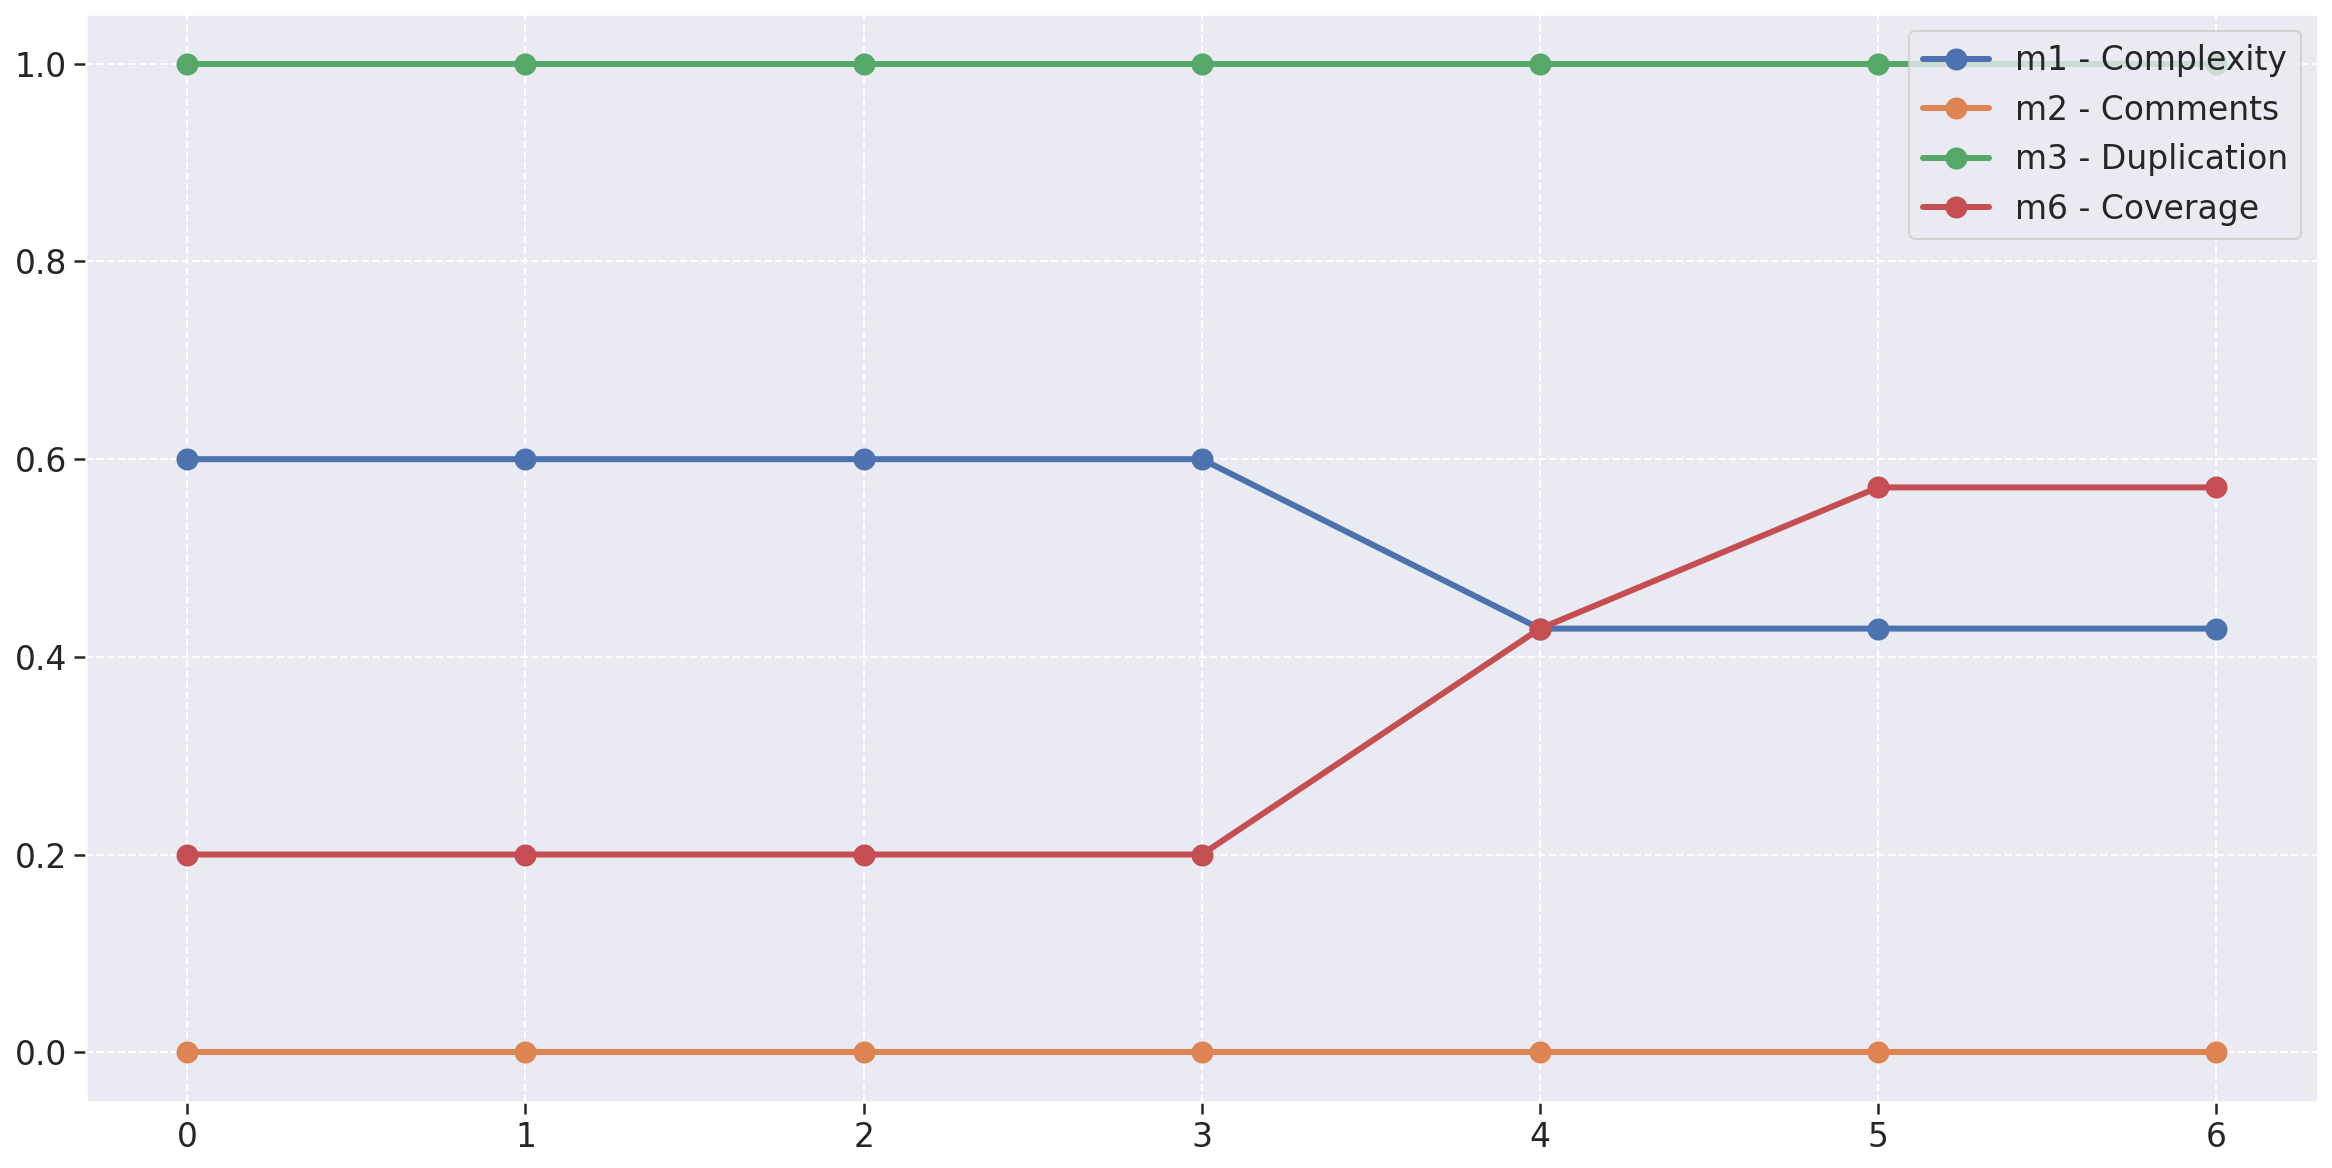

In [158]:
fig = plt.figure(figsize=(20, 10))

plt.plot(cli_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(cli_metrics['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(cli_metrics['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
# plt.plot(cli_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(cli_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(cli_metrics['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

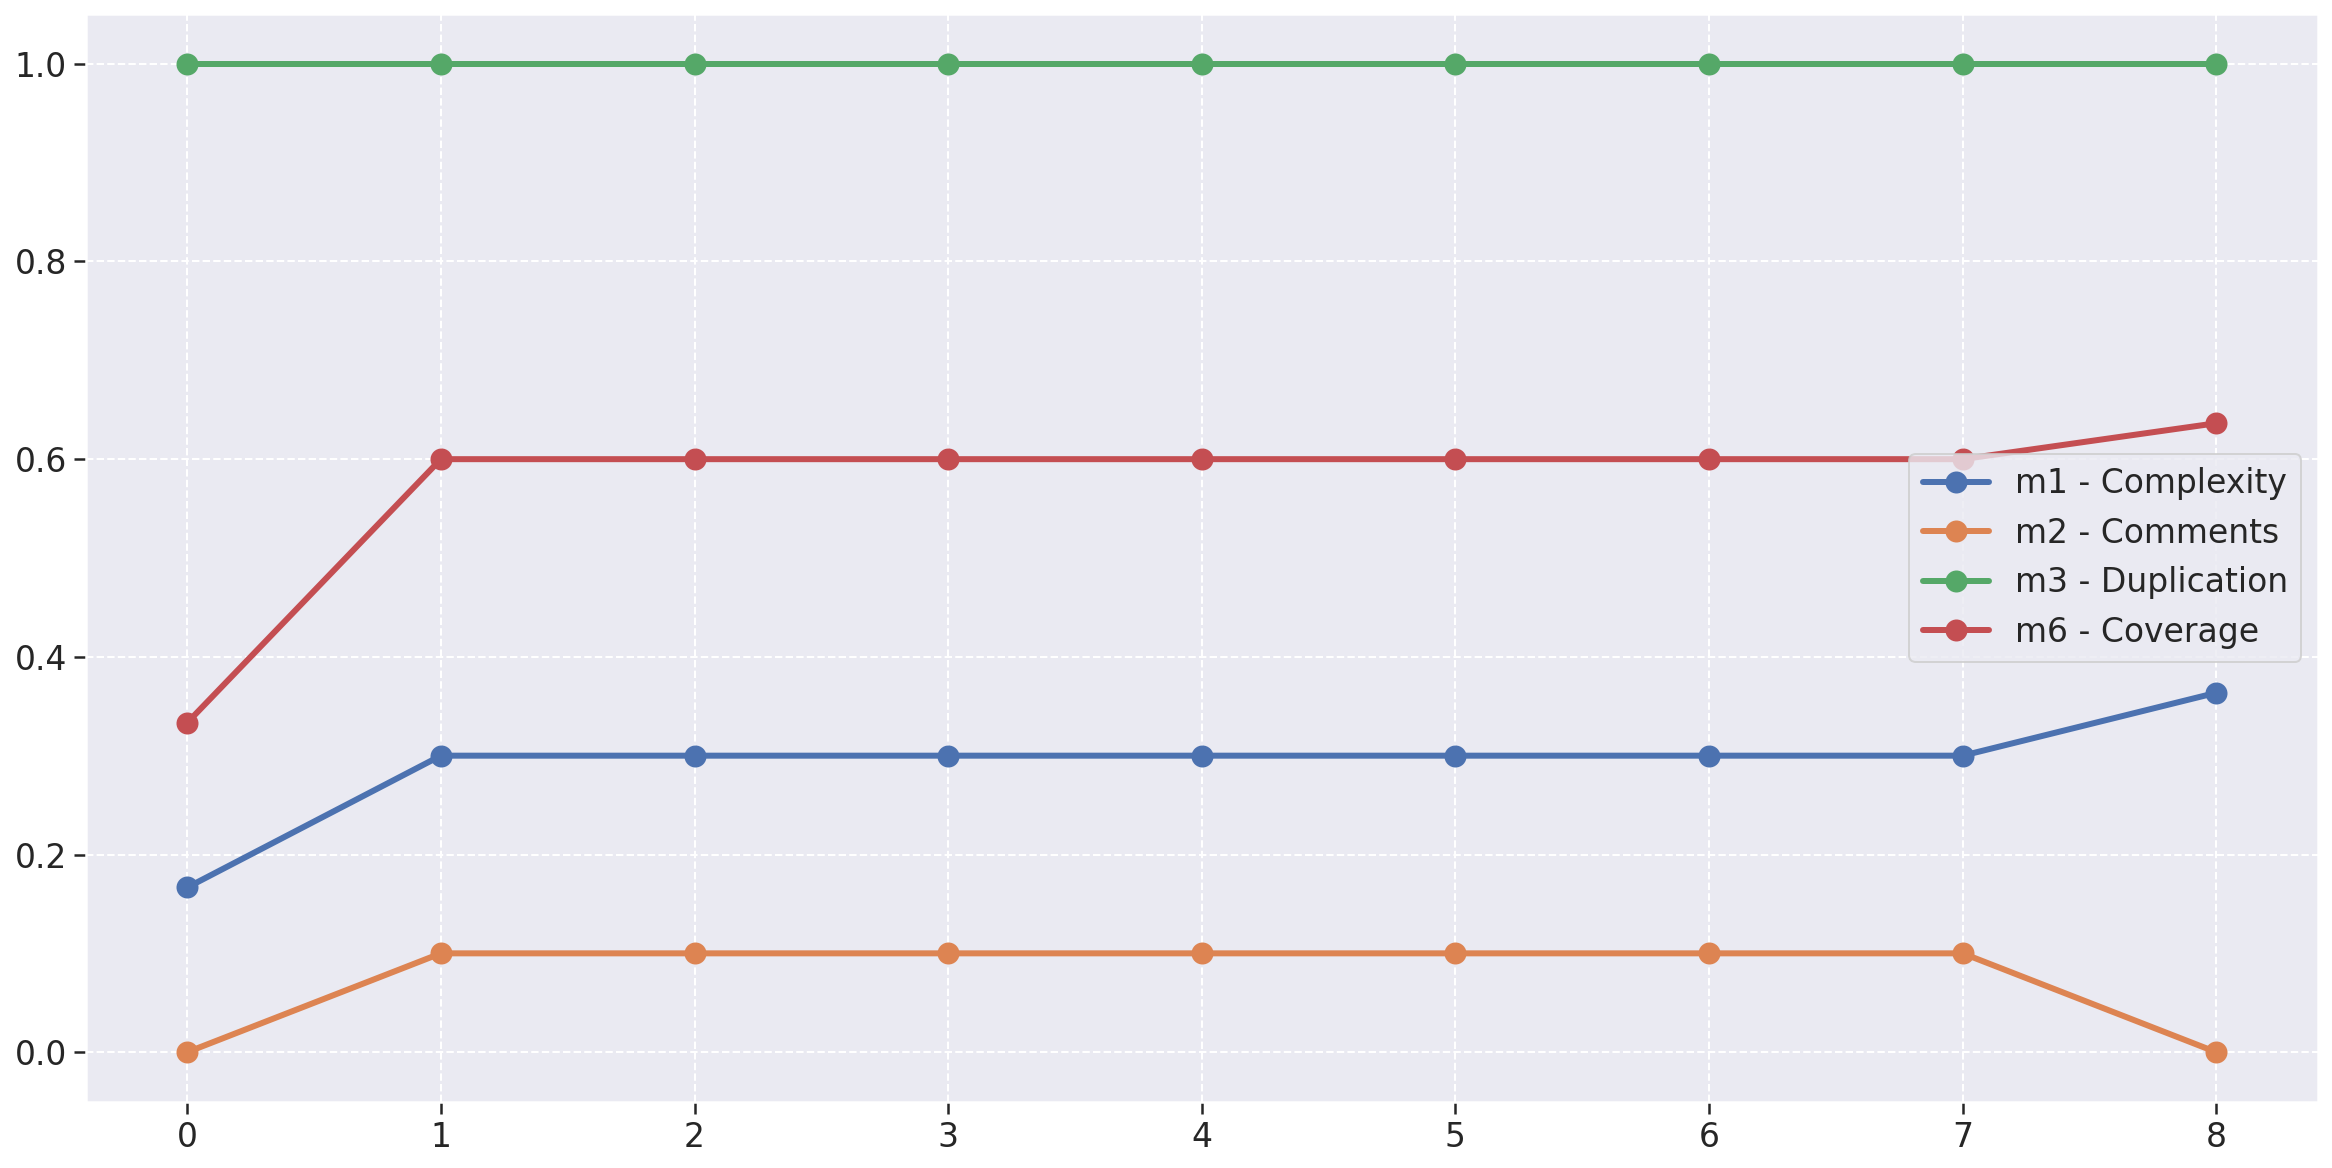

In [159]:
fig = plt.figure(figsize=(20, 10))

plt.plot(service_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(service_metrics['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(service_metrics['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
# plt.plot(service_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(service_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(service_metrics['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

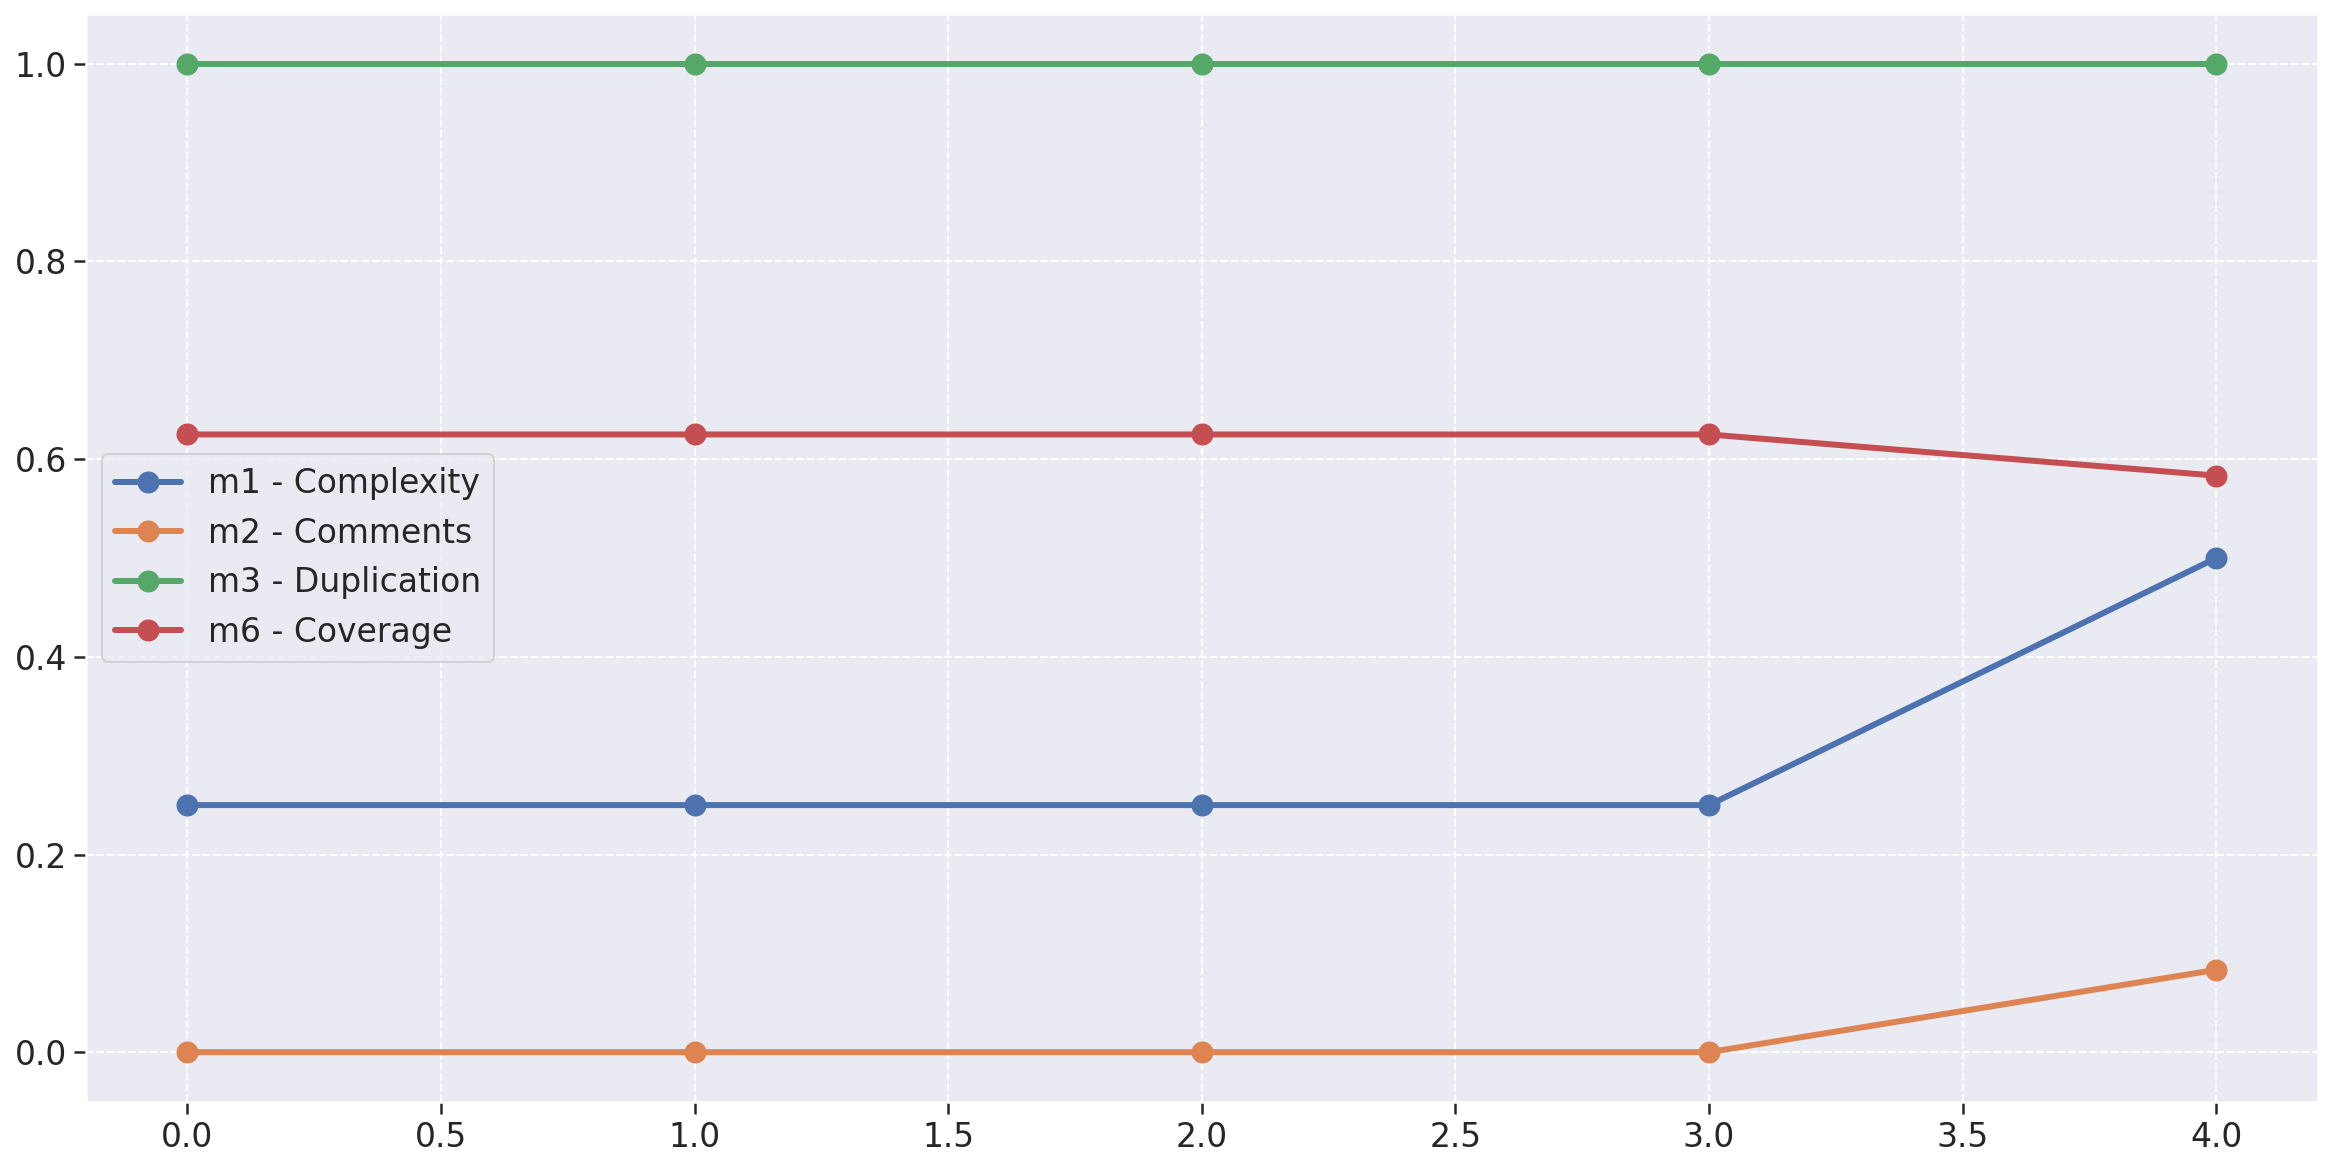

In [160]:
fig = plt.figure(figsize=(20, 10))

plt.plot(core_metrics['m1'], linewidth=3, marker='o', markersize=10, label="m1 - Complexity")
plt.plot(core_metrics['m2'], linewidth=3, marker='o', markersize=10, label="m2 - Comments")
plt.plot(core_metrics['m3'], linewidth=3, marker='o', markersize=10, label="m3 - Duplication")
# plt.plot(core_metrics['m4'], linewidth=3, marker='o', markersize=10, label="m4")
# plt.plot(core_metrics['m5'], linewidth=3, marker='o', markersize=10, label="m5")
plt.plot(core_metrics['m6'], linewidth=3, marker='o', markersize=10, label="m6 - Coverage")

plt.legend(loc='best')

### Sub characteristic aggregation

- You must do this for each of your repositories

In [164]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

cli_metrics['code_quality'] = ((cli_metrics['m1']*pm1) + (cli_metrics['m2']*pm2) + (cli_metrics['m3']*pm3)) * psc1
service_metrics['code_quality'] = ((service_metrics['m1']*pm1) + (service_metrics['m2']*pm2) + (service_metrics['m3']*pm3)) * psc1
core_metrics['code_quality'] = ((core_metrics['m1']*pm1) + (core_metrics['m2']*pm2) + (core_metrics['m3']*pm3)) * psc1

cli_metrics['testing_status'] = cli_metrics['m6'] * psc2
service_metrics['testing_status'] = service_metrics['m6'] * psc2
core_metrics['testing_status'] = core_metrics['m6'] * psc2


In [ ]:
# TODO: Continue here

fig = plt.figure(figsize=(20, 10))


plt.plot(repo1['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['code_quality'], linewidth=3, marker='o', markersize=5)
...

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(repo1['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['testing_status'], linewidth=3, marker='o', markersize=5)
...


In [ ]:
metrics_df = pd.concat([repo1_metrics, repo2_metrics, ...], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [ ]:
metrics_df

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5)


plt.ylim(.45,.7)

In [ ]:
fig = plt.figure(figsize=(20, 10))


plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5)


plt.ylim(.45,.7)


In [ ]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('data/fga-eps-mds-YYYY_SEMESTRE_UNB-NOME_PROJETO-NOME_REPOSITORIO{}-VERSAO_RELEASE.xlsx'.form(currentDateTime), index = False)
metrics_df.to_csv('data/fga-eps-mds-YYYY_SEMESTRE_UNB-NOME_PROJETO-NOME_REPOSITORIO-{}-VERSAO_RELEASE.csv'.format(currentDateTime), index = False)